# Segmentation
Segmentation - a process selecting contours on an image. Contour - is a set of fully connected edges that form a closed loop. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

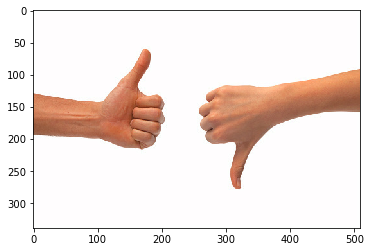

In [3]:
image = cv2.cvtColor(cv2.imread('thumbs-up-down.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(image)

Above is an image of two hands, making a thumbs up and down.
The task will be to determine some information about the shape of these contours.
## Segmentation 1 - Contour detection
cv2.findContours() Should give you a list of contours if you lucky with edge detection preprocessing.

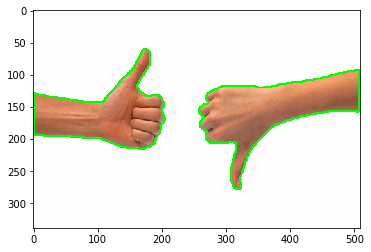

In [4]:
## cv2 finds contours of white object on black background 
# Convert to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
# Create a binary thresholded image
retVal, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)
# Find contours from thresholded image
retVal, contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the original image
contour_image = np.copy(image)
cv2.drawContours(contour_image, contours, -1, (0,255,0), 2)
plt.imshow(contour_image)

## Perform feature extraction from contour. 
Every contour has a number of features that you can calculate, including the area of the contour, it's orientation (the direction that most of the contour is pointing in), it's perimeter, and many other properties outlined in [OpenCV documentation](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html). You may fit line, box or ellipse to extract features relevant to your case.

355.7686767578125 165.4895477294922 142.11520385742188 254.52098083496094 61.274147033691406
119.72238159179688 146.8223419189453 152.84051513671875 188.97637939453125 84.45772552490234


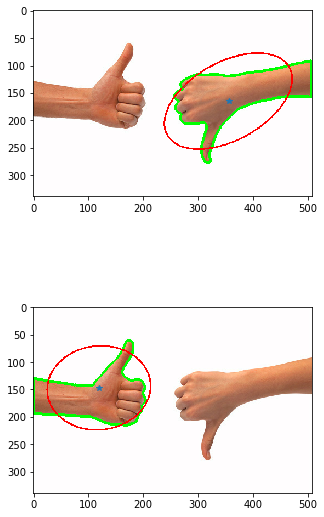

In [29]:
# demo of cv2.fitEllipse()
def draw_elipse_detection(image, selected_contour):
    (x,y), (MA,ma), angle = cv2.fitEllipse(selected_contour)
    print(x,y,MA,ma,angle)
    ellipse = (x,y), (MA,ma), angle

    contour_image = np.copy(image)
    contour_image = cv2.drawContours(contour_image, [selected_contour], 0,  (0,255,0), 3)
    contour_image = cv2.ellipse(contour_image, ellipse, (255,0,0), 2)
    plt.imshow(contour_image)
    plt.plot(x,y, '*')

plt.figure(figsize=(5,10))
plt.subplot(211)
draw_elipse_detection(image, contours[0])
plt.subplot(212)
draw_elipse_detection(image, contours[1])

In [32]:
def orientations(contours):
    """
    Orientation detects and returns the orientations of a list of contours
    The list is in the same order as the contours. 
    Orientation values in degrees fron x zxis:
        0 - flat horizontal line, 
        90 - pointing straight up.
    
    :param cnt: list of contours
    :return: list of orientations of the contours.
    """
    angles = []
    for index, selected_contour in enumerate(contours):
        # find orientation
        # Fit an ellipse to a contour and extract the angle from that ellipse
        (x,y), (MA,ma), angle = cv2.fitEllipse(selected_contour)
        print(x,y,MA,ma, angle, '\n')
        angles.append(round(angle))
    return angles

# perform orientation feature extraction
angles = orientations(contours)
print('Angles of each contour (in degrees): ' + str(angles))


355.7686767578125 165.4895477294922 142.11520385742188 254.52098083496094 61.274147033691406 

119.72238159179688 146.8223419189453 152.84051513671875 188.97637939453125 84.45772552490234 

Angles of each contour (in degrees): [61, 84]


## Perform bounding extraction
Concentrate on left hand contour; use a bounding rectangle to crop the image and better focus on that one hand!

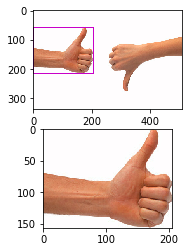

In [33]:
selected_contour = contours[1]
# Find the bounding rectangle of a selected contour
x,y,w,h = cv2.boundingRect(selected_contour)

# Draw the bounding rectangle as a purple box
box_image = np.copy(image)
box_image = cv2.rectangle(box_image, (x,y), (x+w,y+h), (200,0,200),2)
plt.subplot(211)
plt.imshow(box_image)
# Crop using the dimensions of the bounding rectangle (x, y, w, h)
cropped_image = image[y: y + h, x: x + w]
plt.subplot(212)
plt.imshow(cropped_image)

See more at opencv.org [Structural Analysis and Shape Descriptors](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html)

## Segmentation 2 by lines
Looking for rectangular (any line bounded figure) countours after edge detection by using Hough space transform.
### Hough Line Detection
The code we used - a probabilistic Hough transform - is documented, [Hough in OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html).

** Detect Lane Lines** in the image.

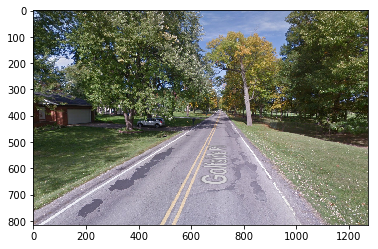

In [4]:
image = cv2.cvtColor(cv2.imread('road-lanes.png'), cv2.COLOR_BGR2RGB)
plt.imshow(image)

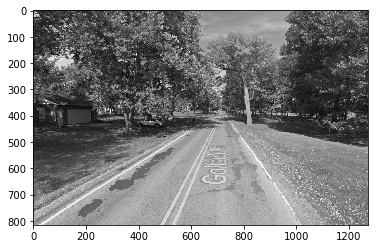

In [42]:
# Convert image to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

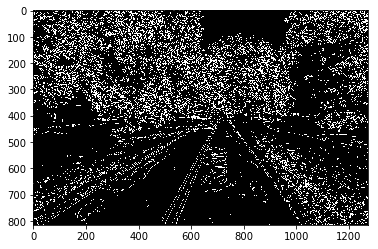

In [64]:
# Peform edge detection with Canny
low_threshold = 100
high_threshold = 250
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

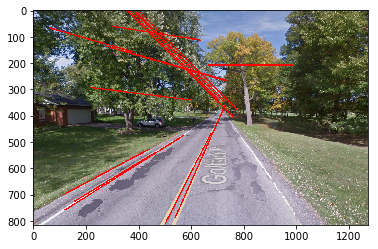

In [108]:
## Define the Hough transform parameters 
## so that lane lines are the only ones detected
rho = 1
theta = np.pi/180
threshold = 60
min_line_length = 300
max_line_gap = 12

# Run Hough on the edge-detected image
# HoughLinesP(edges,rho,theta,threshold, minLineLength,maxLineGap): x1,y1,x2,y2
# HoughLines(edges,rho,theta,threshold): rho,theta
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        np.array([]), min_line_length, max_line_gap)


#creating an image copy to draw lines on
line_image = np.copy(image) 
# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(line_image)

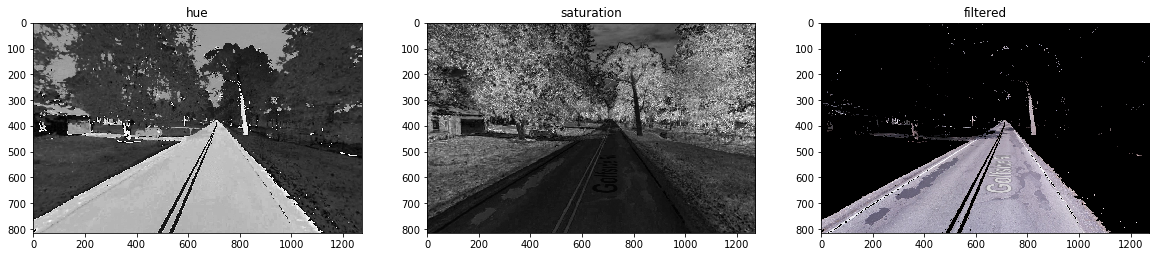

In [135]:
#TODO try white & yellow colors in HSV space instead inRange()
hsvImg = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
h = hsvImg[:,:,0]
s = hsvImg[:,:,1]

loGray = np.array([120, 0, 0])
upGray = np.array([200, 60, 255])
mask = cv2.inRange(hsvImg, loGray, upGray)

filtered = np.copy(image)
filtered[mask==0] = [0,0,0]

f = plt.figure(figsize=(20,7))
plt.subplot(131)
plt.title('hue')
plt.imshow(h, cmap='gray')
plt.subplot(132)
plt.title('saturation')
plt.imshow(s, cmap='gray')
plt.subplot(133)
plt.title('filtered')
plt.imshow(filtered)

filtered[mask!=0] = [255,255,255]

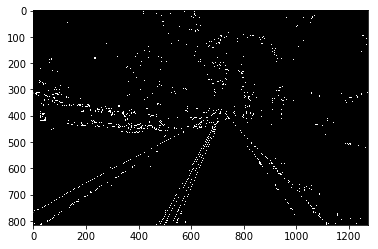

In [138]:
# Peform edge detection with Canny
low_threshold = 0
high_threshold = 100
edges = cv2.Canny(filtered, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

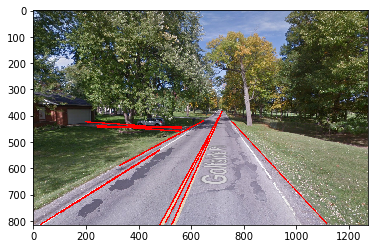

In [142]:
## Define the Hough transform parameters 
## so that lane lines are the only ones detected
rho = 1
theta = np.pi/180
threshold = 60
min_line_length = 300
max_line_gap = 30

# Run Hough on the edge-detected image
# HoughLinesP(edges,rho,theta,threshold, minLineLength,maxLineGap): x1,y1,x2,y2
# HoughLines(edges,rho,theta,threshold): rho,theta
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        np.array([]), min_line_length, max_line_gap)


#creating an image copy to draw lines on
line_image = np.copy(image) 
# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(line_image)

## Segmentation 3
### K-means Segmentation as simplest unsupervised learning
K-means clustering and segmentation is documented, [here](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html).
You ask for k groups and hope clustering groups segments the picture into meaningful parts. Unsupervised learning tecniques can be much extended by Deep Learning if lots of data available and training sets carefully chosen.

## Segmentation 4
### Segmentation with Deep Learning (CNN)
You're encouraged to read about the latest CNN segmentation techniques, [here](https://blog.athelas.com/a-brief-history-of-cnns-in-image-segmentation-from-r-cnn-to-mask-r-cnn-34ea83205de4).